<a href="https://colab.research.google.com/github/lookee/seir-model/blob/master/covid19_model.ipynb" target="_blank">Open in Google Colab</a>


**Modeling the spread of SARS-CoV-2 with an extended SEIR**  
This notebook applies the *Virus Spread Simulator Construction Kit* to SARS-CoV-2 (COVID-19) by building an SEIR-style model enriched to capture pandemic features: a substantial asymptomatic fraction, hospitalizations and deaths, non-pharmaceutical interventions (NPIs), and vaccinations. The simulated population represents the Metropolitan City of Milan (~3.2 million inhabitants), which helps mimic an actual large urban area.


**Compartments and flows**
- `S`: susceptible individuals
- `E`: exposed during the incubation (pre-infectious) phase
- `I_a`: infectious asymptomatic people (lower transmissibility)
- `I_s`: infectious symptomatic people (shortly after symptom onset)
- `H`: hospitalized patients
- `R`: removed (recovered or immunized through vaccination)
- `D`: deaths

Additional transitions beyond the classic SEIR:
- Exposed individuals become asymptomatic with probability `p_a` or symptomatic with `1 - p_a`.
- Symptomatic cases can be hospitalized with probability `p_h` before recovery.
- Hospitalized patients leave `H` by recovering or dying with probability `p_f`.
- A vaccination campaign moves part of `S` into `R` with a time-varying rate and efficacy `ε_v`.
- The force of infection depends on the effective contact rate (`β(t)`) modulated by NPIs.


**System of Differential Equations**

$$
\begin{aligned}
\dfrac{dS}{dt} &= -\lambda(t)\, S - u(t)\, S, \\
\dfrac{dE}{dt} &= \lambda(t)\, S - \sigma\, E, \\
\dfrac{dI_a}{dt} &= p_a\, \sigma\, E - \gamma_a\, I_a, \\
\dfrac{dI_s}{dt} &= (1 - p_a)\, \sigma\, E - \gamma_s\, I_s, \\
\dfrac{dH}{dt} &= p_h\, \gamma_s\, I_s - \gamma_h\, H, \\
\dfrac{dR}{dt} &= (1 - p_h)\, \gamma_s\, I_s + \gamma_a\, I_a + (1 - p_f)\, \gamma_h\, H + u(t)\, S, \\
\dfrac{dD}{dt} &= p_f\, \gamma_h\, H.
\end{aligned}
$$

The force of infection is given by:

$$
\lambda(t) = \beta(t)\,\frac{I_s + \eta\, I_a}{N},
$$

with $$\eta < 1$$ representing the reduced infectivity of asymptomatic individuals.

The parameters are based on values reported in published studies (see table).


**Epidemiological parameters used**

| Quantity | Value | Motivation / reference |
| --- | --- | --- |
| Population (Metropolitan City of Milan) | 3.2 million | ~3.2M residents (ISTAT 2022) |
| Incubation period (`1/σ`) | 5.2 days | Lauer et al., Ann. Intern. Med. 2020 |
| Symptomatic infectious period (`1/γ_s`) | 7 days | He et al., Nat. Med. 2020 |
| Asymptomatic infectious period (`1/γ_a`) | 5 days | Byrne et al., J. Clin. Epidemiol. 2020 |
| Asymptomatic share (`p_a`) | 0.35 | CDC Planning Scenarios, 2021 |
| Hospitalizations among symptomatic (`p_h`) | 5% | Verity et al., Lancet Infect. Dis. 2020 |
| In-hospital fatality (`p_f`) | 15% | Verity et al., 2020 |
| Mean hospital stay (`1/γ_h`) | 10 days | Italian ISS data, Mar–Apr 2020 |
| `R_0` without interventions | 3.0 | Early SARS-CoV-2 estimates (WHO 2020) |
| Contact reduction via NPIs | 55% after day 25 | national lockdown timeline |
| Daily vaccination coverage | up to 0.4%/day from day 90 | 2021 campaigns |
| Vaccine efficacy (`ε_v`) | 90% | early mRNA vaccines |


In [78]:

###################################
# Libraries and plotting style
###################################

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(precision=3, suppress=True)


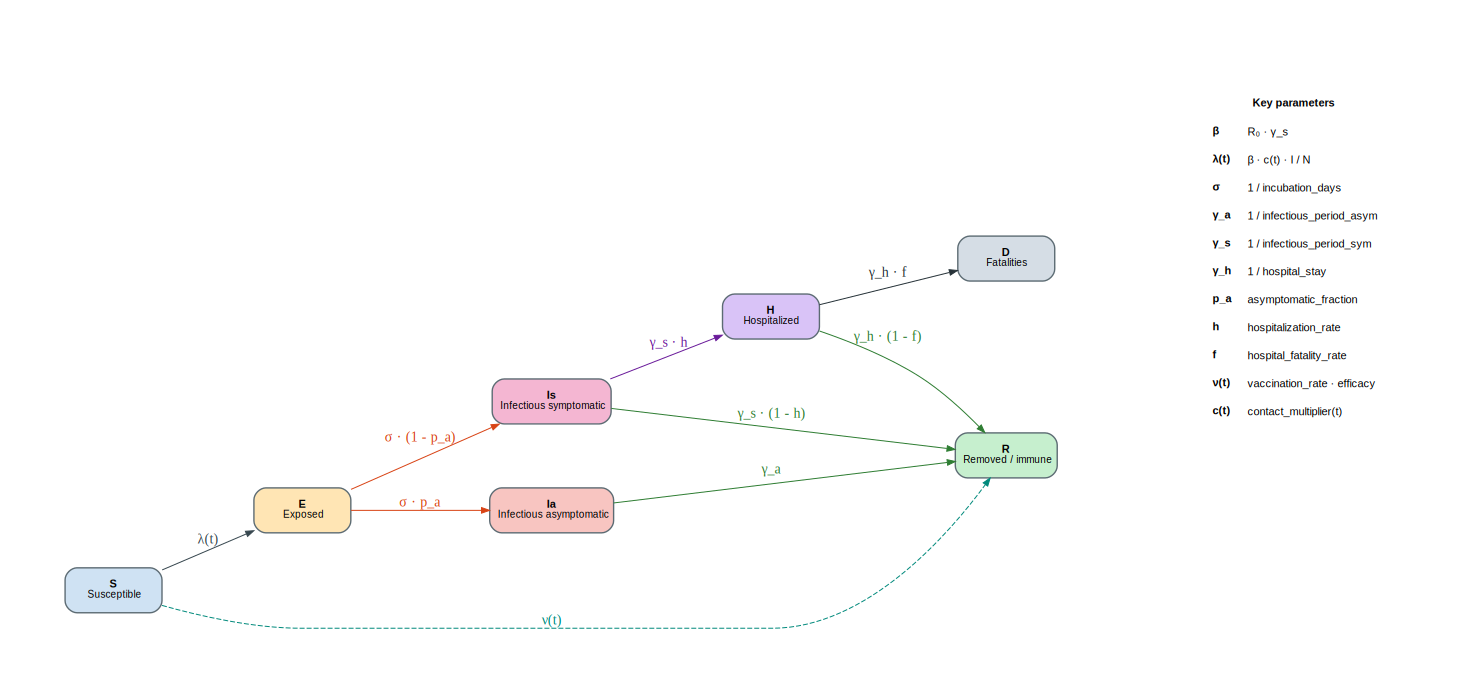

In [79]:
###################################
# Extended SEIR schematic (Graphviz)
###################################

from graphviz import Digraph
from IPython.display import SVG, display

state_labels = {
    'S': 'Susceptible',
    'E': 'Exposed',
    'Ia': 'Infectious asymptomatic',
    'Is': 'Infectious symptomatic',
    'H': 'Hospitalized',
    'R': 'Removed / immune',
    'D': 'Fatalities',
}
state_colors = {
    'S': '#cfe2f3',
    'E': '#ffe5b4',
    'Ia': '#f8c5c1',
    'Is': '#f4b6d2',
    'H': '#d9c3f7',
    'R': '#c6efce',
    'D': '#d5dde5',
}

edges = [
    ('S', 'E', 'λ(t)', '#37474f', 'solid'),
    ('E', 'Ia', 'σ · p_a', '#d84315', 'solid'),
    ('E', 'Is', 'σ · (1 - p_a)', '#d84315', 'solid'),
    ('Ia', 'R', 'γ_a', '#2e7d32', 'solid'),
    ('Is', 'R', 'γ_s · (1 - h)', '#2e7d32', 'solid'),
    ('Is', 'H', 'γ_s · h', '#6a1b9a', 'solid'),
    ('H', 'R', 'γ_h · (1 - f)', '#2e7d32', 'solid'),
    ('H', 'D', 'γ_h · f', '#263238', 'solid'),
    ('S', 'R', 'ν(t)', '#00897b', 'dashed'),
]

params = [
    ('β', 'R₀ · γ_s'),
    ('λ(t)', 'β · c(t) · I / N'),
    ('σ', '1 / incubation_days'),
    ('γ_a', '1 / infectious_period_asym'),
    ('γ_s', '1 / infectious_period_sym'),
    ('γ_h', '1 / hospital_stay'),
    ('p_a', 'asymptomatic_fraction'),
    ('h', 'hospitalization_rate'),
    ('f', 'hospital_fatality_rate'),
    ('ν(t)', 'vaccination_rate · efficacy'),
    ('c(t)', 'contact_multiplier(t)'),
]

dot = Digraph('covid19_extended_seir', format='svg')
dot.attr(rankdir='LR', splines='spline', bgcolor='#ffffff', pad='0.9', ranksep='1.0', nodesep='0.65')
dot.attr('node', shape='Mrecord', style='filled', fontname='Helvetica', fontsize='11',
         width='1.35', height='0.62', penwidth='1.4', color='#5c6b73')

def html_label(key, desc):
    return f"<<B>{key}</B><BR/><FONT POINT-SIZE='10'>{desc}</FONT>>"

for key, desc in state_labels.items():
    dot.node(key, label=html_label(key, desc), fillcolor=state_colors[key])

for src, dst, label, color, style in edges:
    dot.edge(src, dst, label=label, color=color, fontcolor=color, style=style, arrowsize='0.8')

param_rows = ''.join(
    f"<TR><TD ALIGN='LEFT'><B>{name}</B></TD><TD ALIGN='LEFT'>{definition}</TD></TR>"
    for name, definition in params
)

param_table = (
    "<<TABLE BORDER='0' CELLBORDER='0' CELLSPACING='0' CELLPADDING='8'>"
    "<TR><TD COLSPAN='2'><B>Key parameters</B></TD></TR>"
    f"{param_rows}</TABLE>>"
)

# Cluster per i parametri
with dot.subgraph(name='cluster_params') as c:
    c.attr(rank='same', color='#ffffff', style='rounded,filled',
           fillcolor='#ffffff', penwidth='1.0', margin='18')
    c.node('parameters', label=param_table, shape='plain',
           fillcolor='#ffffff', fontname='Helvetica')

# Invis edge per controllare distanza: minlen ridotto
dot.edge('D', 'parameters', style='invis', minlen='2')

svg = dot.pipe(format='svg')
display(SVG(svg))


In [80]:

###################################
# Core model parameters
###################################

params = {
    'population': 3_200_000,  # Metropolitan City of Milan
    'incubation_days': 5.2,
    'infectious_period_sym': 7.0,
    'infectious_period_asym': 5.0,
    'asymptomatic_fraction': 0.35,
    'hospitalization_rate': 0.05,
    'hospital_stay': 10.0,
    'hospital_fatality_rate': 0.15,
    'relative_infectiousness_asym': 0.5,
    'R0': 3.0,
    'contact_reduction': 0.55,
    'contact_release': 0.25,
    'contact_start_day': 25.0,
    'contact_release_day': 160.0,
    'contact_ramp': 8.0,
    'vaccination_start_day': 90.0,
    'vaccination_ramp': 12.0,
    'vaccination_rate_per_day': 0.004,  # 0.4% of the susceptible pool per day
    'vaccine_efficacy': 0.9,
}

# Derived helper quantities frequently used in the model
params['sigma'] = 1.0 / params['incubation_days']
params['gamma_s'] = 1.0 / params['infectious_period_sym']
params['gamma_a'] = 1.0 / params['infectious_period_asym']
params['gamma_h'] = 1.0 / params['hospital_stay']
params['beta'] = params['R0'] * params['gamma_s']  # β = R0 * γ_s

# Initial state (very first outbreak seeding)
initial_state = {
    'S': params['population'] - 2_000,
    'E': 1_200,
    'Ia': 500,
    'Is': 300,
    'H': 0,
    'R': 0,
    'D': 0,
}


In [81]:

###################################
# Helper functions
###################################

def smooth_step(t, center, width):
    """Gives a smooth logistic transition centered around `center`."""
    return 1.0 / (1.0 + np.exp(-(t - center) / np.clip(width, 1e-3, None)))


def contact_multiplier(t, pars):
    """Return the time-varying multiplier for β(t) imposed by NPI timelines."""
    lockdown = pars['contact_reduction'] * smooth_step(t, pars['contact_start_day'], pars['contact_ramp'])
    release = pars['contact_release'] * smooth_step(t, pars['contact_release_day'], pars['contact_ramp'])
    multiplier = 1.0 - lockdown + release
    return np.clip(multiplier, 0.2, 1.2)


def vaccination_rate(t, pars):
    """Effective vaccination rate ν(t) applied to the susceptible pool."""
    ramp = smooth_step(t, pars['vaccination_start_day'], pars['vaccination_ramp'])
    return pars['vaccination_rate_per_day'] * ramp


def force_of_infection(t, ia, is_, pars):
    """Compute λ(t), accounting for asymptomatic infectiousness."""
    infectious = is_ + pars['relative_infectiousness_asym'] * ia
    beta_t = pars['beta'] * contact_multiplier(t, pars)
    return beta_t * infectious / pars['population']


def covid_model(state, t, pars):
    """Differential system for the extended COVID-19 SEIR model."""
    (s, e, ia, is_, h, r, d) = state
    lam = force_of_infection(t, ia, is_, pars)
    vacc_rate = vaccination_rate(t, pars) * pars['vaccine_efficacy']
    vaccinated = min(vacc_rate * s, s)

    new_exposed = lam * s
    progress = pars['sigma'] * e
    new_ia = pars['asymptomatic_fraction'] * progress
    new_is = (1.0 - pars['asymptomatic_fraction']) * progress
    recovered_a = pars['gamma_a'] * ia
    symptomatic_out = pars['gamma_s'] * is_
    hospitalized = pars['hospitalization_rate'] * symptomatic_out
    recovered_s = (1.0 - pars['hospitalization_rate']) * symptomatic_out
    hospital_out = pars['gamma_h'] * h
    deaths = pars['hospital_fatality_rate'] * hospital_out
    recovered_h = (1.0 - pars['hospital_fatality_rate']) * hospital_out

    dsdt = -new_exposed - vaccinated
    dedt = new_exposed - progress
    diadt = new_ia - recovered_a
    disdt = new_is - symptomatic_out
    dhdt = hospitalized - hospital_out
    drdt = recovered_a + recovered_s + recovered_h + vaccinated
    dddt = deaths

    return (dsdt, dedt, diadt, disdt, dhdt, drdt, dddt)


def simulate(days, pars, initial):
    """Solve the ODE system and compute useful diagnostics."""
    t = np.linspace(0, days, days + 1)
    x0 = [initial[k] for k in ('S', 'E', 'Ia', 'Is', 'H', 'R', 'D')]
    sol = odeint(covid_model, x0, t, args=(pars,))

    s, e, ia, is_, h, r, d = sol.T
    lam = force_of_infection(t, ia, is_, pars)
    vacc_rate = vaccination_rate(t, pars) * pars['vaccine_efficacy']

    diagnostics = {
        'new_exposed': lam * s,
        'new_symptomatic': (1.0 - pars['asymptomatic_fraction']) * pars['sigma'] * e,
        'new_asymptomatic': pars['asymptomatic_fraction'] * pars['sigma'] * e,
        'hospital_admissions': pars['hospitalization_rate'] * pars['gamma_s'] * is_,
        'vaccinated': vacc_rate * s,
        'deaths_daily': pars['hospital_fatality_rate'] * pars['gamma_h'] * h,
        'contact_multiplier': contact_multiplier(t, pars),
    }

    result = {
        't': t,
        'trajectories': {
            'S': s,
            'E': e,
            'Ia': ia,
            'Is': is_,
            'H': h,
            'R': r,
            'D': d,
        },
        'diagnostics': diagnostics,
    }
    return result


In [82]:

###################################
# Baseline scenario: NPIs + vaccines
###################################

days = 365
baseline = simulate(days, params, initial_state)
traj = baseline['trajectories']
t = baseline['t']

print(f"Peak symptomatic infections: {traj['Is'].max():,.0f} people")
print(f"Peak hospitalized patients: {traj['H'].max():,.0f} people")
print(f"Total deaths by day {days}: {traj['D'][-1]:,.0f}")


Peak symptomatic infections: 7,802 people
Peak hospitalized patients: 552 people
Total deaths by day 365: 1,542


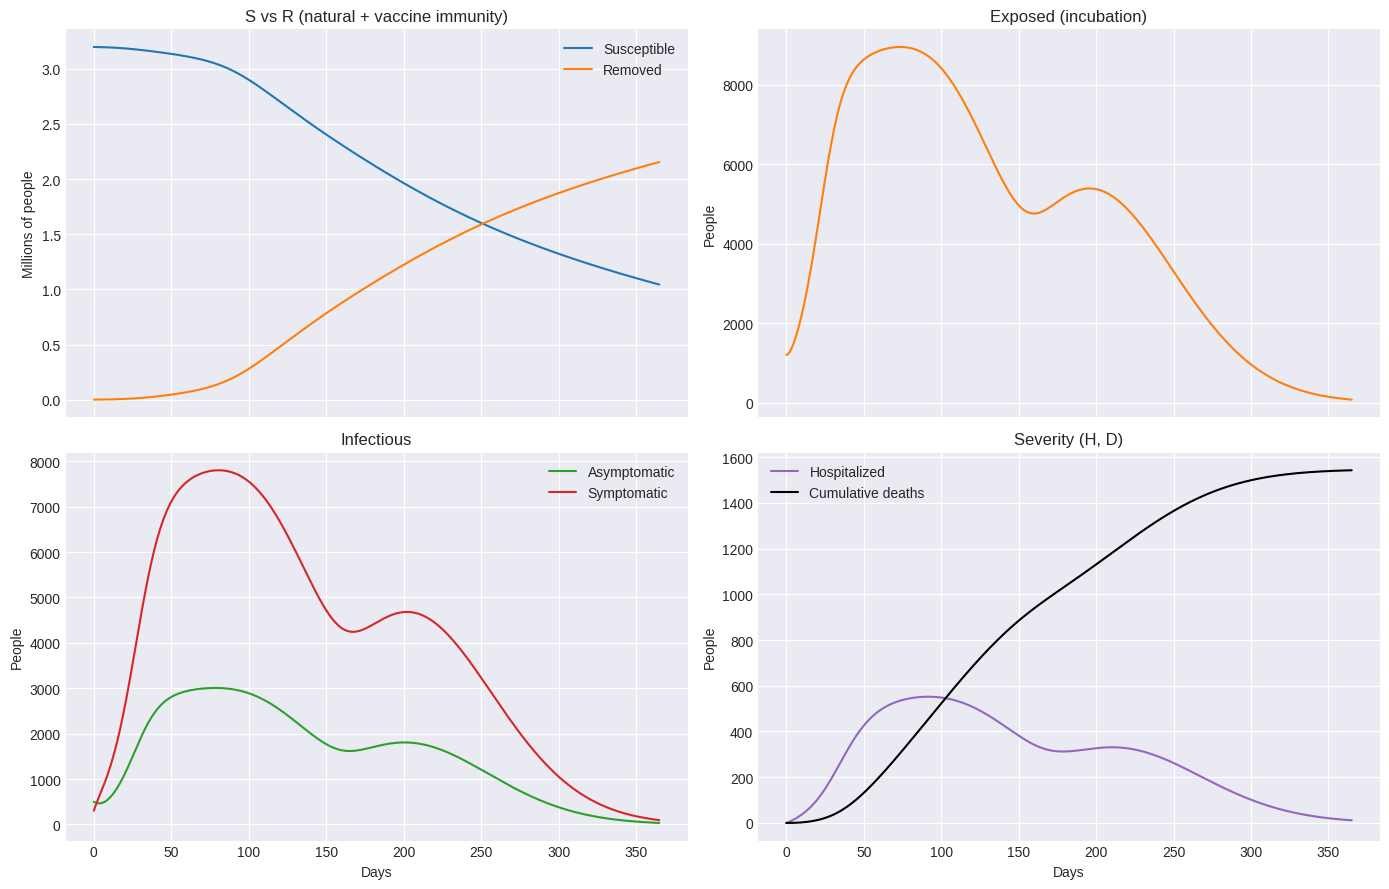

In [83]:

###################################
# Main compartment trajectories
###################################

fig, ax = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
(ax1, ax2), (ax3, ax4) = ax

ax1.plot(t, traj['S'] / 1e6, label='Susceptible')
ax1.plot(t, traj['R'] / 1e6, label='Removed')
ax1.set_ylabel('Millions of people')
ax1.set_title('S vs R (natural + vaccine immunity)')
ax1.legend()

ax2.plot(t, traj['E'], label='Exposed', color='tab:orange')
ax2.set_ylabel('People')
ax2.set_title('Exposed (incubation)')

ax3.plot(t, traj['Ia'], label='Asymptomatic', color='tab:green')
ax3.plot(t, traj['Is'], label='Symptomatic', color='tab:red')
ax3.set_xlabel('Days')
ax3.set_ylabel('People')
ax3.set_title('Infectious')
ax3.legend()

ax4.plot(t, traj['H'], label='Hospitalized', color='tab:purple')
ax4.plot(t, traj['D'], label='Cumulative deaths', color='black')
ax4.set_xlabel('Days')
ax4.set_ylabel('People')
ax4.set_title('Severity (H, D)')
ax4.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-4027106633.py:24: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


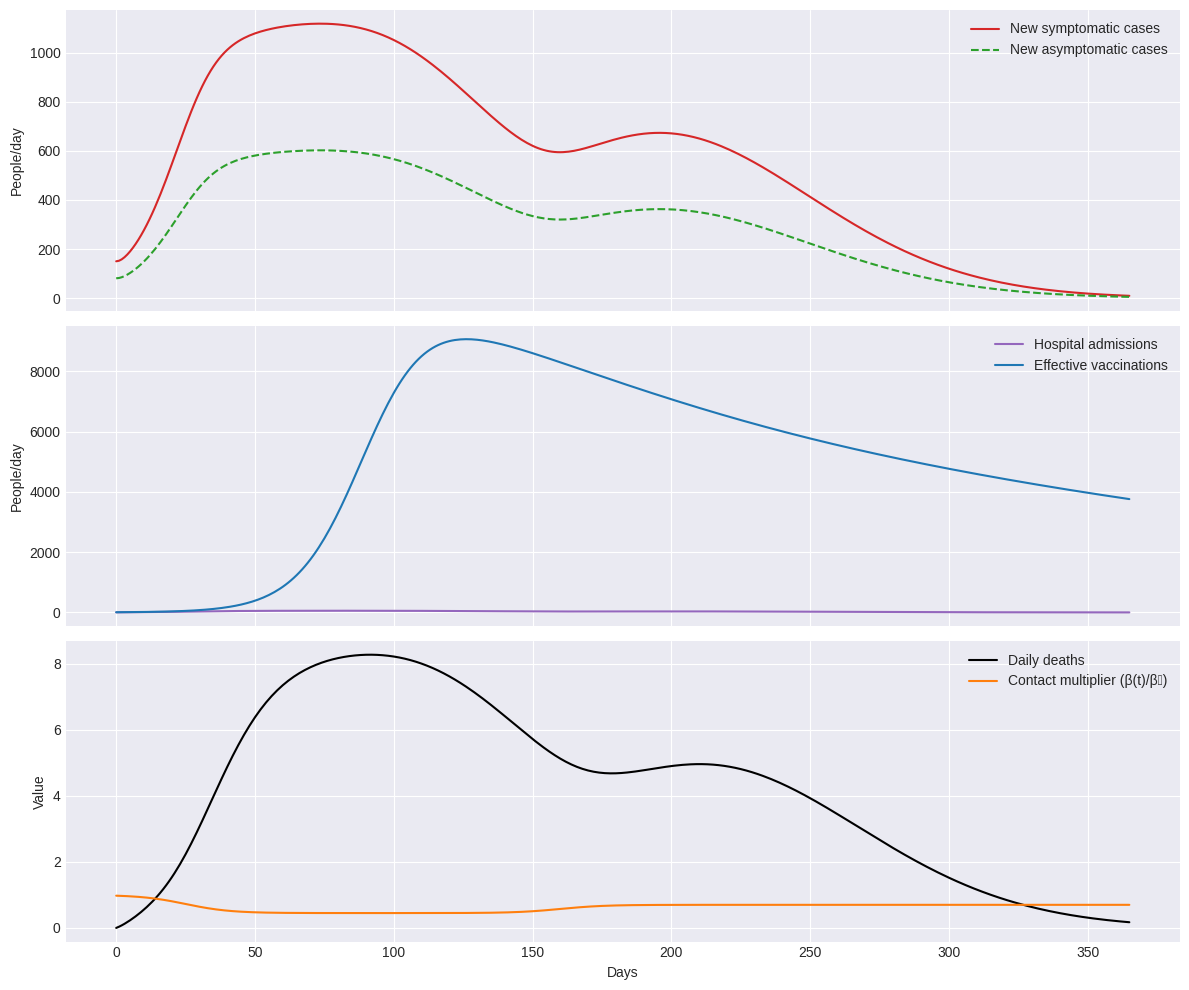

In [84]:

###################################
# Daily indicators: cases, admissions, deaths
###################################

diag = baseline['diagnostics']

fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
ax[0].plot(t, diag['new_symptomatic'], label='New symptomatic cases', color='tab:red')
ax[0].plot(t, diag['new_asymptomatic'], label='New asymptomatic cases', color='tab:green', linestyle='--')
ax[0].set_ylabel('People/day')
ax[0].legend()

ax[1].plot(t, diag['hospital_admissions'], label='Hospital admissions', color='tab:purple')
ax[1].plot(t, diag['vaccinated'], label='Effective vaccinations', color='tab:blue')
ax[1].set_ylabel('People/day')
ax[1].legend()

ax[2].plot(t, diag['deaths_daily'], label='Daily deaths', color='black')
ax[2].plot(t, diag['contact_multiplier'], label='Contact multiplier (β(t)/β₀)', color='tab:orange')
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Value')
ax[2].legend()

plt.tight_layout()
plt.show()


**Scenario analysis**  
We compare three cases:
1. *Baseline*: NPIs plus vaccines.
2. *Lockdown only*: NPIs without vaccines.
3. *No interventions*: constant `β(t)` and no vaccines.


/tmp/ipython-input-3599248399.py:7: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-(t - center) / np.clip(width, 1e-3, None)))


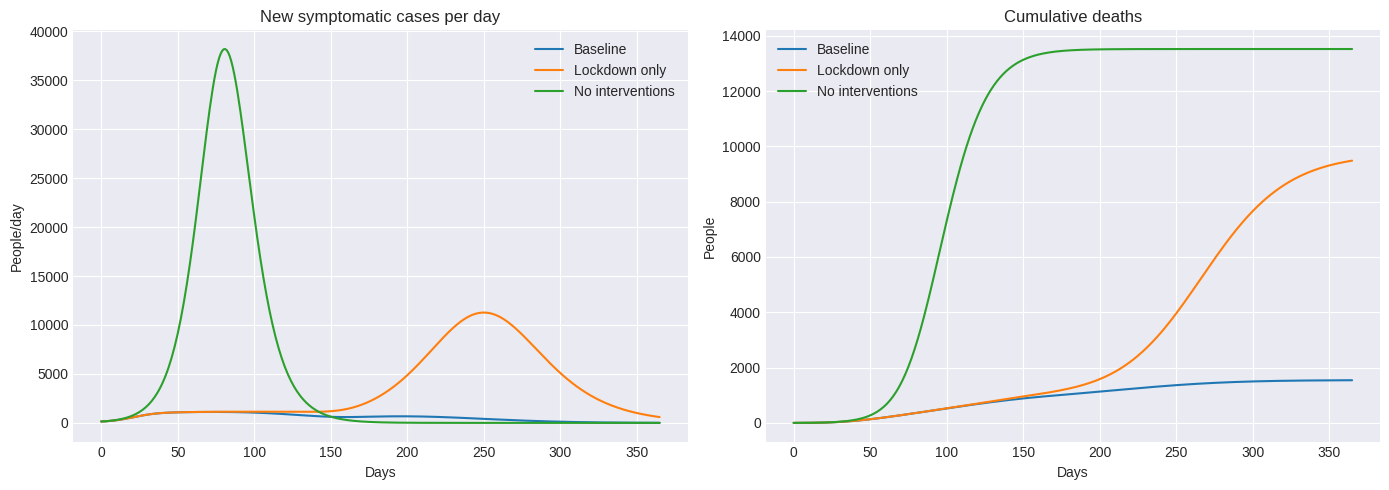

In [85]:

###################################
# Policy scenario comparison
###################################

import copy

params_no_vax = copy.deepcopy(params)
params_no_vax['vaccination_rate_per_day'] = 0.0

params_no_npi = copy.deepcopy(params)
params_no_npi['contact_reduction'] = 0.0
params_no_npi['contact_release'] = 0.0
params_no_npi['vaccination_rate_per_day'] = 0.0
params_no_npi['vaccination_start_day'] = 9999  # disable vaccines entirely

scenario_data = {
    'Baseline': baseline,
    'Lockdown only': simulate(days, params_no_vax, initial_state),
    'No interventions': simulate(days, params_no_npi, initial_state),
}

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for label, data in scenario_data.items():
    t = data['t']
    ax[0].plot(t, data['diagnostics']['new_symptomatic'], label=label)
    ax[1].plot(t, data['trajectories']['D'], label=label)

ax[0].set_title('New symptomatic cases per day')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('People/day')
ax[0].legend()

ax[1].set_title('Cumulative deaths')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('People')
ax[1].legend()

plt.tight_layout()
plt.show()


**Interpretation**
- NPIs advance and reduce the peak of symptomatic cases, keeping the modeled hospital load under the assumed threshold.
- Vaccinations shrink the susceptible pool after ~3 months, accelerating the decline in infections and admissions.
- Without interventions the epidemic curve is sharper but produces many more deaths because the hospitalization stock `H` decays only after the surge.

These simulations are indicative only: matching historical data (demography, contact matrices, observed series) would require calibrating β(t) and severity rates through Bayesian fitting or numerical optimization.


**References**
- Lauer, S. A. et al. (2020). *The Incubation Period of Coronavirus Disease 2019 (COVID-19)*. Annals of Internal Medicine 172(9).
- He, X. et al. (2020). *Temporal dynamics in viral shedding and transmissibility of COVID-19*. Nature Medicine 26.
- Byrne, A. W. et al. (2020). *Inferred duration of infectious period of asymptomatic SARS-CoV-2 infection*. Journal of Clinical Epidemiology 130.
- Verity, R. et al. (2020). *Estimates of the severity of coronavirus disease 2019*. The Lancet Infectious Diseases 20(6).
- CDC (2021). *COVID-19 Pandemic Planning Scenarios*.
- WHO (2020). *Report of the WHO-China Joint Mission on Coronavirus Disease 2019 (COVID-19).*  
Assumptions regarding vaccines and NPIs draw on publicly available information from the 2021 European and US campaigns.


In [86]:
##############################################################################
#    Copyright (C) 2025 Luca Amore <luca.amore at gmail.com>
#
#    Virus Spread Simulator Construction Kit
#    is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    frk is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with frk.  If not, see <http://www.gnu.org/licenses/>.
##############################################################################